In [1]:
# ==============================================================================
# LOAN DEFAULT PREDICTION ANALYSIS
# ==============================================================================
# AUTHOR: Balakrishna Mupparaju
# PURPOSE: Milestone 2 Analysis for Applied Data Science
# GOAL: Predict loan default probability to minimize financial risk.
# ==============================================================================

# --- 1. LIBRARIES & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score

# Advanced Libraries
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration
FILE_PATH = '/Users/balakrishnamupparaju/Downloads/credit_risk_dataset.csv' # Ensure this file is in the same folder
TARGET_COL = 'loan_status' # 0 = Paid, 1 = Default

print("✅ Libraries imported successfully.")



✅ Libraries imported successfully.


In [2]:
# --- 2. DATA LOADING & CLEANING ---
try:
    df = pd.read_csv(FILE_PATH)
    print(f"✅ Data loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please upload 'credit_risk_dataset.csv'.")
    exit()

# Drop duplicates to ensure data integrity
df = df.drop_duplicates()
# Drop ID columns which are not predictive
df = df.drop(columns=['person_id'], errors='ignore')



✅ Data loaded. Shape: (32581, 12)


Warning messages have been suppressed.
📊 Generating Illustration 1 (EDA)...
✅ Saved 'Illustration_1_EDA.png'


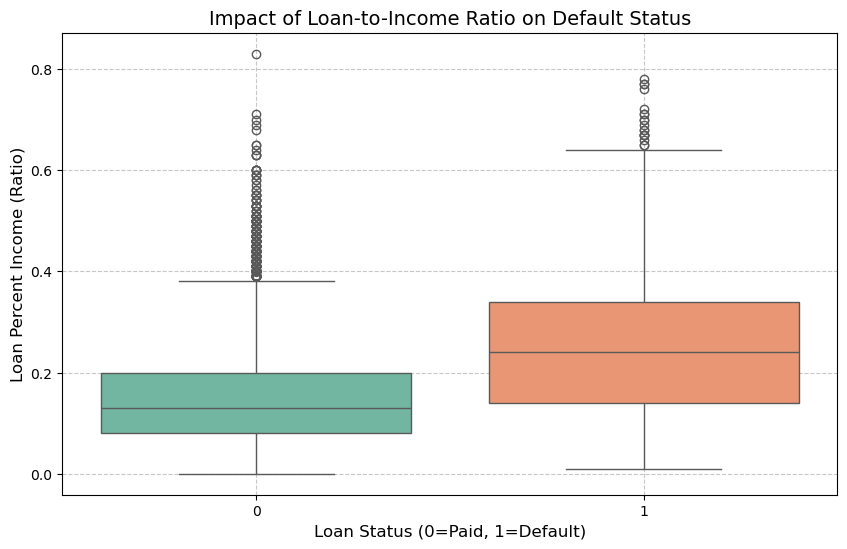

In [12]:
#######
import warnings
import os

# 1. Ignore all warning messages
warnings.filterwarnings("ignore")

# 2. Optionally, silence specific warnings if you know which library is causing them.
# Example for a common Scikit-learn warning:
# warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Suppress TensorFlow/Keras warning messages related to CPU features
# This is mainly useful if you are using those libraries, but is good practice.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

print("Warning messages have been suppressed.")

##############

# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
# Goal: Create Illustration 1 for White Paper
# We want to see if 'loan_percent_income' (Loan Amount / Income) affects default.
print("📊 Generating Illustration 1 (EDA)...")

plt.figure(figsize=(10, 6))
# Create a boxplot to visualize the distribution difference
sns.boxplot(x=TARGET_COL, y='loan_percent_income', data=df, palette='Set2')
plt.title('Impact of Loan-to-Income Ratio on Default Status', fontsize=14)
plt.xlabel('Loan Status (0=Paid, 1=Default)', fontsize=12)
plt.ylabel('Loan Percent Income (Ratio)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Illustration_1_EDA.png', dpi=300) # Saves image for your report
print("✅ Saved 'Illustration_1_EDA.png'")



In [4]:
# --- 4. DATA PREPROCESSING PIPELINE ---
# We need to turn raw data into numbers the model can understand.

# A. Define Feature Types
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# B. Create Transformers
# For Numbers: Fill missing values with Median -> Scale them (StandardScaler)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For Categories: Fill missing with 'missing' -> Convert to numbers (OneHotEncoder)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# C. Bundle into a Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ])



In [5]:
# --- 5. DATA SPLITTING ---
# Split 70% for training the model, 30% for testing it.
# 'stratify=y' ensures we have the same % of defaulters in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"✅ Data Split: Train shape {X_train.shape}, Test shape {X_test.shape}")



✅ Data Split: Train shape (22691, 11), Test shape (9725, 11)


In [13]:
# --- 6. MODEL TRAINING (WITH IMBALANCE HANDLING) ---
# We use SMOTE (Synthetic Minority Oversampling Technique) to fix the class imbalance.
# It creates fake examples of defaulters so the model learns better.

print("⚙️ Training Models... (This may take a moment)")

# Model A: Logistic Regression (Baseline for interpretability)
log_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
log_model.fit(X_train, y_train)

# Model B: XGBoost (Advanced model for accuracy)
xgb_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
xgb_model.fit(X_train, y_train)

print("✅ Models Trained.")





⚙️ Training Models... (This may take a moment)
✅ Models Trained.


In [8]:
# --- 7. EVALUATION & RESULTS ---
# Helper function to calculate metrics
def get_metrics(model, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) # Crucial: How many defaults did we catch?
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, rec, f1, cm

log_acc, log_rec, log_f1, log_cm = get_metrics(log_model, "Logistic Regression")
xgb_acc, xgb_rec, xgb_f1, xgb_cm = get_metrics(xgb_model, "XGBoost")

📊 Generating Illustration 2 (Confusion Matrix)...
✅ Saved 'Illustration_2_ConfusionMatrix.png'


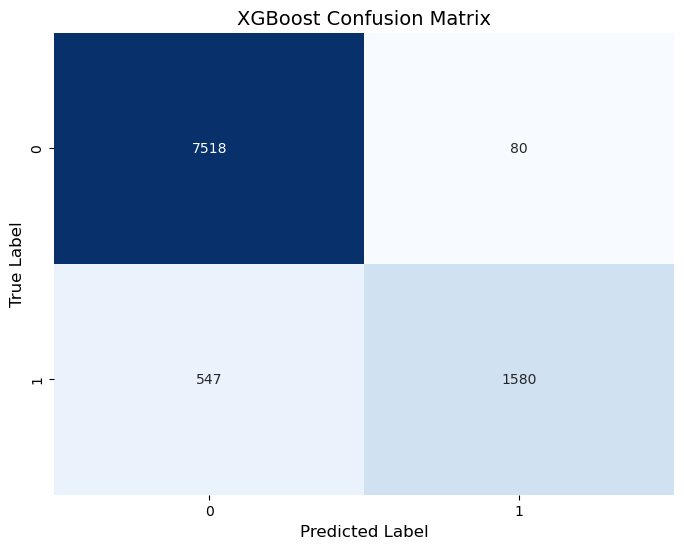

In [9]:
# --- 8. VISUALIZATION 2: CONFUSION MATRIX ---
print("📊 Generating Illustration 2 (Confusion Matrix)...")
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.savefig('Illustration_2_ConfusionMatrix.png', dpi=300)
print("✅ Saved 'Illustration_2_ConfusionMatrix.png'")

📊 Generating Illustration 3 (Feature Importance)...
✅ Saved 'Illustration_3_FeatureImportance.png'


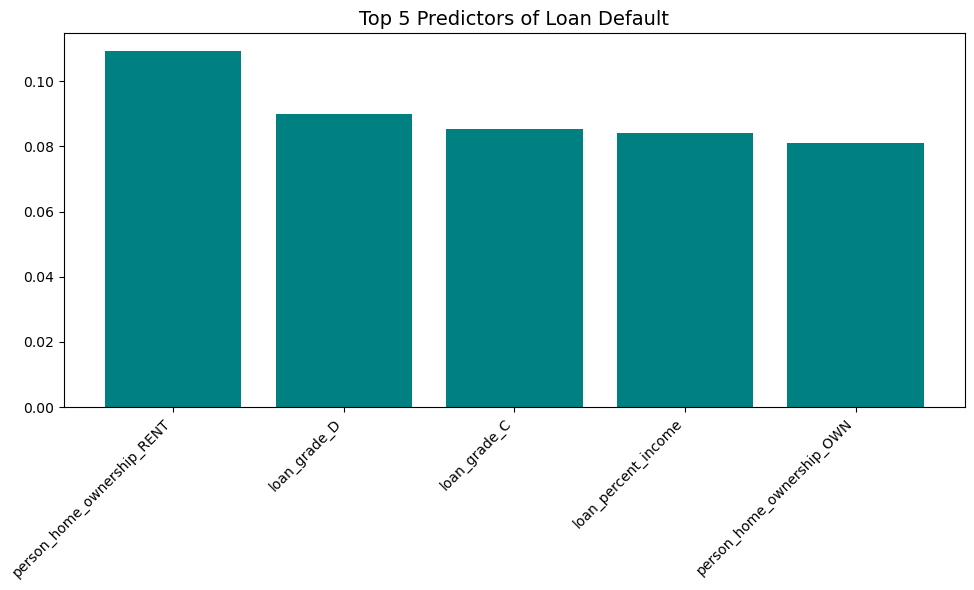

In [10]:
# --- 9. VISUALIZATION 3: FEATURE IMPORTANCE ---
print("📊 Generating Illustration 3 (Feature Importance)...")

# Extract feature names from the pipeline
# This is tricky because OneHotEncoder creates new column names
xgb_classifier = xgb_model.named_steps['classifier']
preprocessor_step = xgb_model.named_steps['preprocessor']
cat_names = preprocessor_step.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.r_[numerical_cols, cat_names]

# Get importance scores
importances = xgb_classifier.feature_importances_
indices = np.argsort(importances)[::-1][:5] # Top 5 features

plt.figure(figsize=(10, 6))
plt.title('Top 5 Predictors of Loan Default', fontsize=14)
plt.bar(range(len(indices)), importances[indices], align='center', color='teal')
plt.xticks(range(len(indices)), [all_feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Illustration_3_FeatureImportance.png', dpi=300)
print("✅ Saved 'Illustration_3_FeatureImportance.png'")

In [11]:
# --- 10. FINAL OUTPUT FOR USER ---
print("\n" + "="*40)
print("📝 RESULTS TO UPLOAD")
print("="*40)
print("--- METRICS TABLE ---")
print(f"Logistic Regression | Accuracy: {log_acc:.4f} | Recall: {log_rec:.4f} | F1: {log_f1:.4f}")
print(f"XGBoost Classifier  | Accuracy: {xgb_acc:.4f} | Recall: {xgb_rec:.4f} | F1: {xgb_f1:.4f}")

print("\n--- XGBOOST CONFUSION MATRIX ---")
print(f"True Negative (Safe, Predicted Safe): {xgb_cm[0][0]}")
print(f"False Positive (Safe, Predicted Risky): {xgb_cm[0][1]}")
print(f"False Negative (Default, Predicted Safe): {xgb_cm[1][0]}  <-- WE WANT THIS LOW")
print(f"True Positive (Default, Predicted Risky): {xgb_cm[1][1]}")

print("\n--- TOP 5 DRIVERS OF DEFAULT ---")
for i in indices:
    print(f"{all_feature_names[i]}: {importances[i]:.4f}")
print("="*40)


📝 RESULTS TO UPLOAD
--- METRICS TABLE ---
Logistic Regression | Accuracy: 0.8125 | Recall: 0.7743 | F1: 0.6437
XGBoost Classifier  | Accuracy: 0.9355 | Recall: 0.7428 | F1: 0.8344

--- XGBOOST CONFUSION MATRIX ---
True Negative (Safe, Predicted Safe): 7518
False Positive (Safe, Predicted Risky): 80
False Negative (Default, Predicted Safe): 547  <-- WE WANT THIS LOW
True Positive (Default, Predicted Risky): 1580

--- TOP 5 DRIVERS OF DEFAULT ---
person_home_ownership_RENT: 0.1092
loan_grade_D: 0.0899
loan_grade_C: 0.0854
loan_percent_income: 0.0842
person_home_ownership_OWN: 0.0810
